<a href="https://colab.research.google.com/github/nunorfidalgo/AD2425_TP/blob/main/AD2425_TP_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup, Version check and Common imports


In [ ]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras import layers

import kagglehub
import pathlib
import pandas as pd

from warnings import filterwarnings
filterwarnings('ignore')
from keras.preprocessing.image import load_img, img_to_array

# to make this notebook's output stable across runs
np.random.seed(42)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

print('Python version: ', sys.version_info)
print('TF version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')
tf.test.is_gpu_available()

Python version:  sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
TF version:  2.18.0
Keras version:  3.8.0
GPU is available


I0000 00:00:1745644176.832981     375 gpu_device.cc:2022] Created device /device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


True

# Vars

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 150
EPOCHS=20

# Data Fetching and Loading

In [ ]:
# Download the Intel Image Classification dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Path to dataset files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


# List paths

In [ ]:
seg_pred_path = (path + '/seg_pred/seg_pred/')
print("Path to seg_pred files:", seg_pred_path)

seg_test_path = (path + '/seg_test/seg_test/')
print("Path to seg_test files:", seg_test_path)

seg_train_path = (path + '/seg_train/seg_train/')
print("Path to seg_train files:", seg_train_path)

Path to seg_pred files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_pred/seg_pred/
Path to seg_test files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test/
Path to seg_train files: /home/rafeiro/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train/


# Count images of each directory

In [ ]:
seg_pred_dir = pathlib.Path(seg_pred_path)
seg_pred_img_count = len(list(seg_pred_dir.glob('*.jpg')))
print("Count pred images: ", seg_pred_img_count)

seg_test_dir = pathlib.Path(seg_test_path)
seg_test_img_count = len(list(seg_test_dir.glob('*/*.jpg')))
print("Count test images: ", seg_test_img_count)

seg_train_dir = pathlib.Path(seg_train_path)
seg_train_img_count = len(list(seg_train_dir.glob('*/*.jpg')))
print("Count train images: ", seg_train_img_count)

Count pred images:  7301
Count test images:  3000
Count train images:  14034


# Creation of the dataset objects

 The images in the folders are not divided in train and validation datasets

 The following code divides samples into 70% training and 30% validation.

 No test set is created


In [ ]:
# training dataset - 70%
train_ds = keras.preprocessing.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# validition dataset - 30%
val_ds = keras.preprocessing.image_dataset_from_directory(
    seg_train_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

# test dataset
test_ds = keras.preprocessing.image_dataset_from_directory(
    seg_test_dir,
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

Found 14034 files belonging to 6 classes.
Using 9824 files for training.
Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
Found 3000 files belonging to 6 classes.


# Dataset detailed information

In [ ]:
print('Nr. of classes: ', len(class_names))
print('Classes: ', class_names)

# Cardinality
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())
print('Cardinalidade Teste: ', test_ds.cardinality().numpy())

Nr. of classes:  6
Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Cardinalidade Treino:  307
Cardinalidade Validacão:  132
Cardinalidade Teste:  94


# Count the number of images in each class


## in train dir:

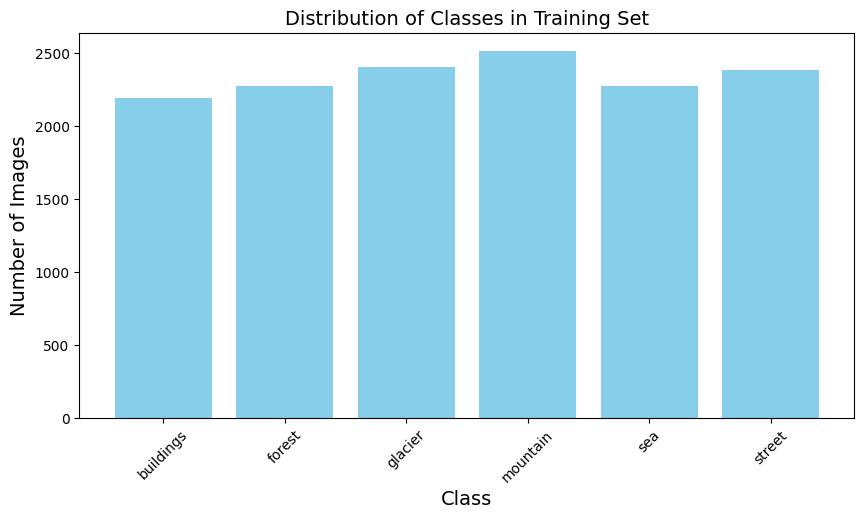

In [ ]:
class_counts = {class_name: len(os.listdir(os.path.join(seg_train_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Training Set')
plt.xticks(rotation=45)
plt.show()

## in test dir:

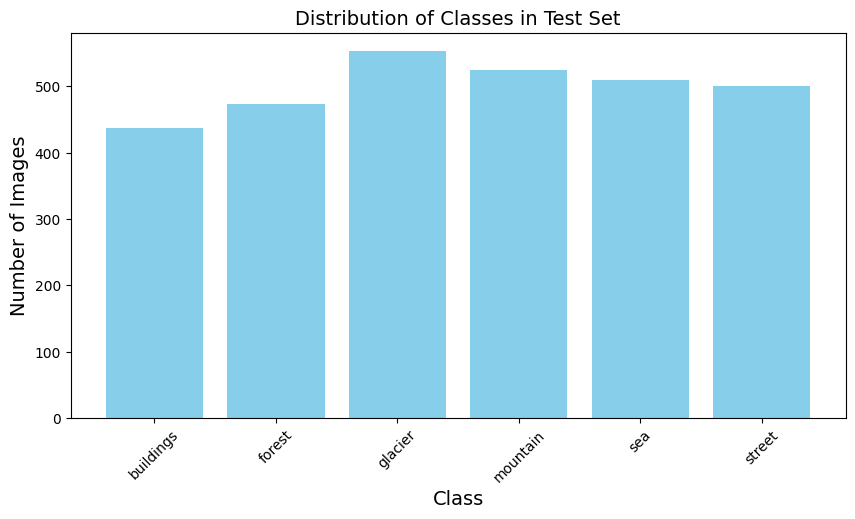

In [ ]:
class_counts = {class_name: len(os.listdir(os.path.join(seg_test_dir, class_name))) for class_name in class_names}

# Plot the distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Test Set')
plt.xticks(rotation=45)
plt.show()

# Visualize a few examples

2025-04-26 06:09:38.289265: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


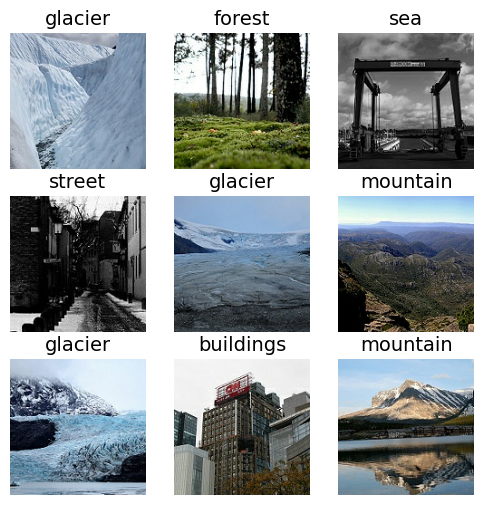

In [ ]:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255.)
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Data Augmentation


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(factor=0.3),
    layers.RandomShear(0.2),
    layers.RandomZoom(0.2),
])

# Visualize examples of augmented images


2025-04-26 06:09:38.567971: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-26 06:09:39.072210: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


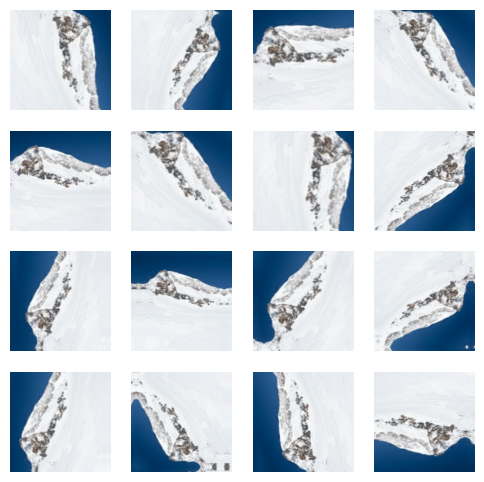

In [ ]:
plt.figure(figsize=(6, 6))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy()/255.)
    plt.axis("off")

# Creation of a baseline CNN




In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation(inputs)
a = layers.Rescaling(1./255)(a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model_baseline_CCN = keras.Model(inputs=inputs, outputs=outputs)

# Check the limit for the maximum number of parameters

In [ ]:
model_baseline_CCN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    23,040,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,079,174 (88.04 MB)

 Trainable params: 23,079,174 (88.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model compilation

In [ ]:
model_baseline_CCN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train for X epochs

## Using EarlyStopping, when the val_accuracy has not improved after 10 epochs, stop training.


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                        mode='max',restore_best_weights=True,patience=10)

In [ ]:
history = model_baseline_CCN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.3389 - loss: 2.0042 - val_accuracy: 0.4181 - val_loss: 1.7690
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5179 - loss: 1.2048 - val_accuracy: 0.4356 - val_loss: 1.8538
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5558 - loss: 1.1223 - val_accuracy: 0.4394 - val_loss: 1.7389
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5840 - loss: 1.0789 - val_accuracy: 0.4375 - val_loss: 1.5241
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5985 - loss: 1.0476 - val_accuracy: 0.4639 - val_loss: 1.5025
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6119 - loss: 1.0171 - val_accuracy: 0.5192 - val_loss: 1.2811
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6225 - loss: 0.9981 - val_accuracy: 0.4879 - val_loss: 1.4023
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6104 - loss: 1.0095 - val_ac

# Visualize results (both accuracy and loss)

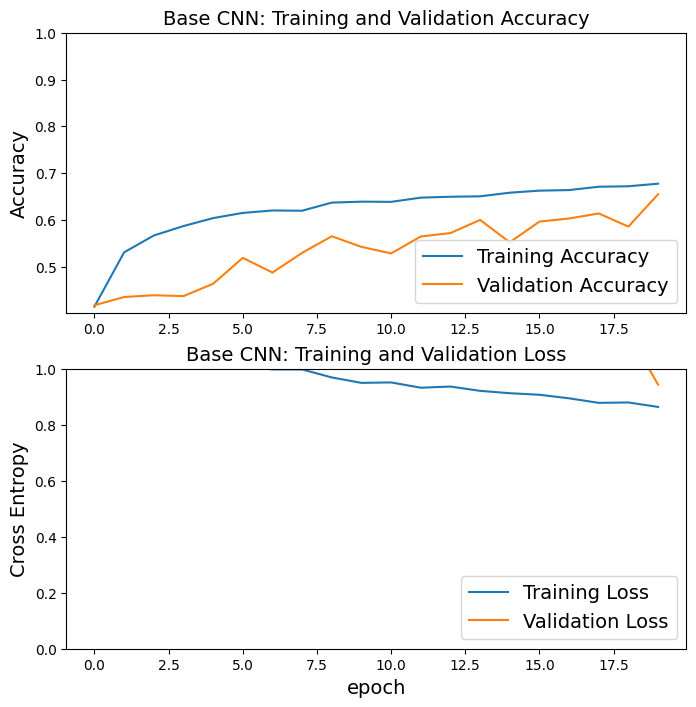

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Base CNN: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Base CNN: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model_baseline_CCN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6588 - loss: 0.9272


[0.9512028098106384, 0.6493333578109741]

# Creation of a Model 2 CNN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation(inputs)
a = layers.Rescaling(1./255)(a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(128, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model2_CNN = keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model2_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 720000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    92,160,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,312,070 (352.14 MB)

 Trainable params: 92,312,070 (352.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history2_CNN = model2_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3706 - loss: 2.6631 - val_accuracy: 0.3523 - val_loss: 2.1257
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5237 - loss: 1.1938 - val_accuracy: 0.3781 - val_loss: 1.9491
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5481 - loss: 1.1516 - val_accuracy: 0.4352 - val_loss: 1.7430
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.5659 - loss: 1.1069 - val_accuracy: 0.4121 - val_loss: 1.7778
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5741 - loss: 1.0843 - val_accuracy: 0.4511 - val_loss: 1.5830
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5926 - loss: 1.0699 - val_accuracy: 0.4796 - val_loss: 1.4970
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6035 - loss: 1.0383 - val_accuracy: 0.5185 - val_loss: 1.4437
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.6161 - loss: 1.0076 - 

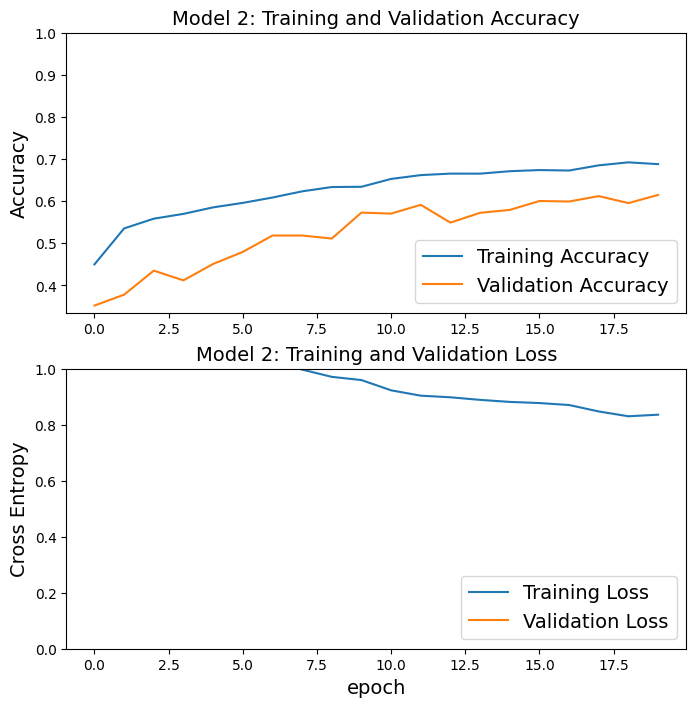

In [ ]:
acc = history2_CNN.history['accuracy']
val_acc = history2_CNN.history['val_accuracy']

loss = history2_CNN.history['loss']
val_loss = history2_CNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model 2: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model 2: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model2_CNN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6131 - loss: 1.0326


[1.0599008798599243, 0.6019999980926514]

# Creation of a Model 3 CNN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation(inputs)
a = layers.Rescaling(1./255)(a)

a = layers.Conv2D(256, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(128, activation='relu') (a)
a = layers.Dropout(0.5) (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model3_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model3_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,599,622 (44.25 MB)

 Trainable params: 11,599,622 (44.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history3_CNN = model3_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.3216 - loss: 1.6486 - val_accuracy: 0.3228 - val_loss: 2.0106
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.4448 - loss: 1.3210 - val_accuracy: 0.3380 - val_loss: 1.9690
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.4697 - loss: 1.2743 - val_accuracy: 0.4390 - val_loss: 1.5652
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.4999 - loss: 1.2245 - val_accuracy: 0.4107 - val_loss: 1.6746
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5087 - loss: 1.1925 - val_accuracy: 0.4827 - val_loss: 1.4067
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5399 - loss: 1.1638 - val_accuracy: 0.5138 - val_loss: 1.2618
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.5333 - loss: 1.1581 - val_accuracy: 0.4962 - val_loss: 1.2893
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.5469 - loss: 1.1377 - 

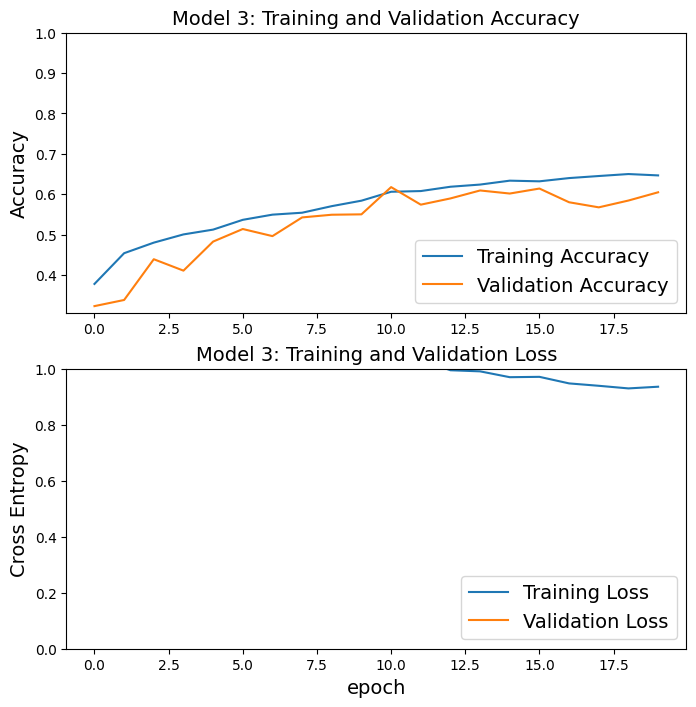

In [ ]:
acc = history3_CNN.history['accuracy']
val_acc = history3_CNN.history['val_accuracy']

loss = history3_CNN.history['loss']
val_loss = history3_CNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model 3: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model 3: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model3_CNN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6268 - loss: 1.0060


[1.0220507383346558, 0.6156666874885559]

# Creation of a Model 4 CNN

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation(inputs)
a = layers.Rescaling(1./255)(a)

a = layers.Conv2D(256, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(256, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Conv2D(128, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)
a = layers.BatchNormalization() (a)

a = layers.Flatten() (a)
a = layers.Dense(256, activation='relu') (a)
a = layers.Dropout(0.5) (a)
a = layers.Dense(128, activation='relu') (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model4_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model4_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    92,160,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,170,694 (355.42 MB)

 Trainable params: 93,169,286 (355.41 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
model4_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history4_CNN = model4_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 72s 223ms/step - accuracy: 0.2697 - loss: 19.9680 - val_accuracy: 0.1739 - val_loss: 1.7921
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 69s 225ms/step - accuracy: 0.2348 - loss: 1.7363 - val_accuracy: 0.3038 - val_loss: 1.6674
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 226ms/step - accuracy: 0.2830 - loss: 1.6620 - val_accuracy: 0.3245 - val_loss: 1.8974
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.2999 - loss: 1.6359 - val_accuracy: 0.2990 - val_loss: 2.8082
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.2984 - loss: 1.6153 - val_accuracy: 0.2931 - val_loss: 2.7139
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.3120 - loss: 1.5941 - val_accuracy: 0.3724 - val_loss: 1.5981
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 227ms/step - accuracy: 0.3433 - loss: 1.5358 - val_accuracy: 0.3086 - val_loss: 1.6392
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.3801 - loss: 

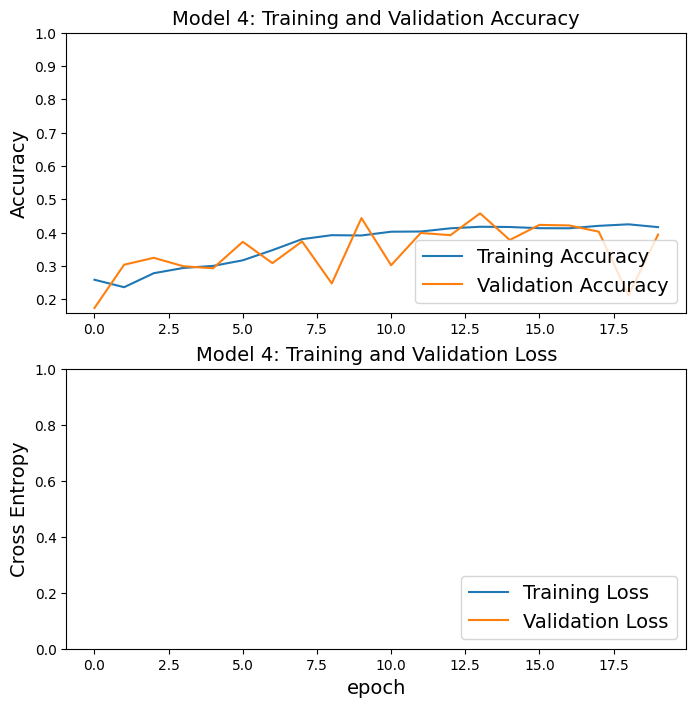

In [ ]:
acc = history4_CNN.history['accuracy']
val_acc = history4_CNN.history['val_accuracy']

loss = history4_CNN.history['loss']
val_loss = history4_CNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model 4: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model 4: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model4_CNN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4280 - loss: 1.3792


[1.3494552373886108, 0.4390000104904175]

# Creation of a Model 5 CNN


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = data_augmentation(inputs)
a = layers.Rescaling(1./255)(a)

a = layers.Conv2D(32, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(32, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(32, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model5_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model5_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 180000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     5,760,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,770,374 (22.01 MB)

 Trainable params: 5,770,374 (22.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model5_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history5_CNN = model5_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3301 - loss: 1.8921 - val_accuracy: 0.3663 - val_loss: 1.7836
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4858 - loss: 1.2516 - val_accuracy: 0.4511 - val_loss: 1.4926
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5422 - loss: 1.1754 - val_accuracy: 0.4950 - val_loss: 1.3143
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5576 - loss: 1.1315 - val_accuracy: 0.4943 - val_loss: 1.4076
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5771 - loss: 1.1031 - val_accuracy: 0.5081 - val_loss: 1.2909
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5898 - loss: 1.0710 - val_accuracy: 0.5169 - val_loss: 1.2564
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5967 - loss: 1.0471 - val_accuracy: 0.5143 - val_loss: 1.2988
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5969 - loss: 1.0386 - val_accu

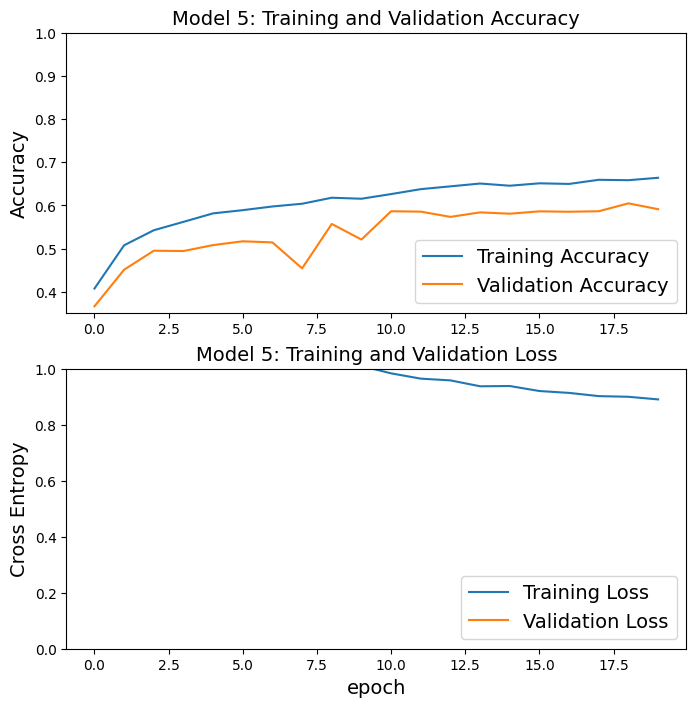

In [ ]:
acc = history5_CNN.history['accuracy']
val_acc = history5_CNN.history['val_accuracy']

loss = history5_CNN.history['loss']
val_loss = history5_CNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model 5: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model 5: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model5_CNN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6153 - loss: 1.0456


[1.0670685768127441, 0.6050000190734863]

---------------------------------------------------

# Creation of a Model 6 CNN


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
a = layers.Rescaling(1./255)(inputs)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)
a = layers.MaxPooling2D() (a)

a = layers.Conv2D(64, 3, activation='relu', padding='same') (a)

a = layers.Flatten() (a)
a = layers.Dense(64, activation='relu') (a)

outputs = keras.layers.Dense(6, activation="softmax") (a)

model6_CNN = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model6_CNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 360000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    23,040,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,079,174 (88.04 MB)

 Trainable params: 23,079,174 (88.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6_CNN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history6_CNN = model6_CNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1745646716.684554     514 service.cc:148] XLA service 0x16c628e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745646716.684989     514 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-04-26 06:51:56.714264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 13/307 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2348 - loss: 5.9399

I0000 00:00:1745646718.484168     514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.4941 - loss: 1.7566 - val_accuracy: 0.6618 - val_loss: 0.8589
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7146 - loss: 0.7609 - val_accuracy: 0.7283 - val_loss: 0.7787
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8325 - loss: 0.4719 - val_accuracy: 0.6736 - val_loss: 1.0142
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8927 - loss: 0.3189 - val_accuracy: 0.6808 - val_loss: 1.0282
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9126 - loss: 0.2561 - val_accuracy: 0.6207 - val_loss: 1.3901
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9519 - loss: 0.1469 - val_accuracy: 0.6967 - val_loss: 1.4305
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9788 - loss: 0.0747 - val_accuracy: 0.7040 - val_loss: 1.6624
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9882 - loss: 0.0451 - val_accuracy: 0.687

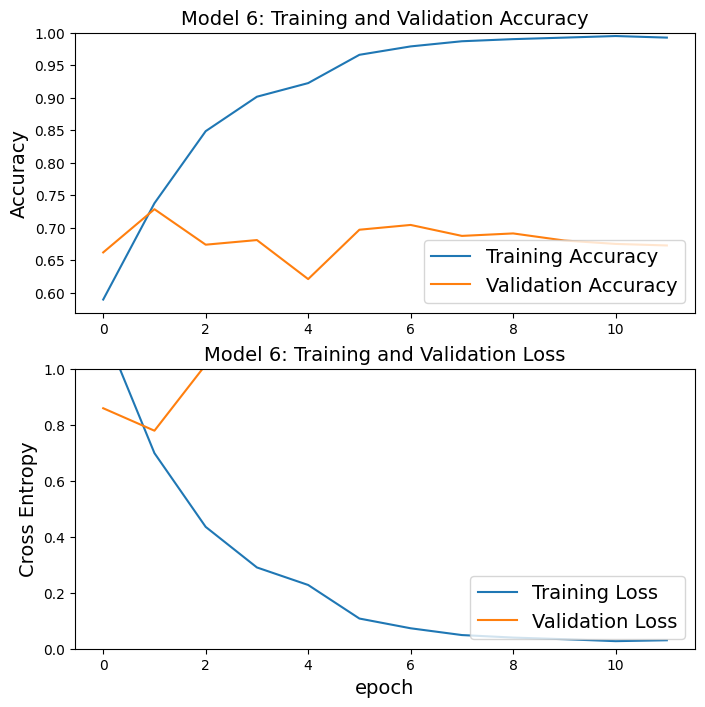

In [ ]:
acc = history6_CNN.history['accuracy']
val_acc = history6_CNN.history['val_accuracy']

loss = history6_CNN.history['loss']
val_loss = history6_CNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Model 6: Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Model 6: Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test the model with test data

In [ ]:
model6_CNN.evaluate(test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7164 - loss: 0.7972


[0.7982456684112549, 0.7183333039283752]